### Installing and Importing necessary libraries

In [1]:
!pip install byol_pytorch -q q q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.1 MB/s eta 0:00:00


In [2]:
# Standard library imports
import json
import math
import os
import random

# Third-party library imports
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
from PIL import Image
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# Deep learning frameworks
import torch
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torchvision
from torchvision import models, transforms as T

# Specialized model imports
from byol_pytorch import BYOL
from transformers import CLIPProcessor, CLIPModel

# Initialize models
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

## Dataloader and Dataset

In [3]:
class BaseArtDataset(Dataset):
    """Base dataset class for art images"""
    def __init__(self, folder_path):
        # Get all image files in the directory
        self.image_files = [f for f in os.listdir(folder_path) 
                          if os.path.isfile(os.path.join(folder_path, f)) and 
                          f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        
        self.folder_path = folder_path
    
    def __len__(self):
        return len(self.image_files)
    
    def _load_image(self, idx):
        """Load image from file"""
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        return Image.open(img_path).convert('RGB'), img_path


class ByolTrainDataset(BaseArtDataset):
    """Dataset for BYOL training (single image input)"""
    def __init__(self, folder_path):
        super().__init__(folder_path)
        # Basic transform for BYOL (minimal since BYOL handles augmentations)
        self.transform = T.Compose([
            T.Resize((256,256)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __getitem__(self, idx):
        image, img_path = self._load_image(idx)        
        # Apply transforms
        image = self.transform(image)            
        return image, img_path


class MetricEvalDataset(BaseArtDataset):
    """Dataset for alignment and uniformity metric evaluation (two augmented views of the same image)"""
    def __init__(self, folder_path):
        super().__init__(folder_path)
        
        # Augmentation pipeline for evaluation metrics
        self.transform = T.Compose([
            T.RandomResizedCrop(256, scale=(0.5, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.5),
            T.RandomGrayscale(p=0.1),
            T.RandomApply([T.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))], p=0.2),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __getitem__(self, idx):
        image, img_path = self._load_image(idx)
        
        # Create two differently augmented versions of the same image
        img1 = self.transform(image)
        img2 = self.transform(image)
            
        return img1, img2, img_path

In [4]:
def create_data_loaders(dataset_path, batch_size=64, train_size=18000, val_size=1000, test_size=1000, num_workers=4):
    """
    Create train, validation, and test data loaders with different configurations:
    - Train loader: BYOL-style single images
    - Val/Test loaders: Pairs of augmented images for metric evaluation
    
    Args:
        dataset_path (str): Path to dataset directory
        batch_size (int): Batch size for loaders
        train_size (int): Number of samples for training
        val_size (int): Number of samples for validation
        test_size (int): Number of samples for testing
        num_workers (int): Number of workers for data loading
        
    Returns:
        dict: Dictionary containing train, val, test loaders and datasets
    """
    # First, get the total list of files and create indices for splitting
    base_dataset = BaseArtDataset(dataset_path)
    dataset_size = len(base_dataset)
    
    # Check if we have enough samples
    required_size = train_size + val_size + test_size
    
    if dataset_size < required_size:
        print(f"Warning: Dataset only has {dataset_size} samples, which is less than the requested {required_size}")
        # Adjust sizes proportionally
        total = train_size + val_size + test_size
        train_size = int(dataset_size * (train_size / total))
        val_size = int(dataset_size * (val_size / total))
        test_size = dataset_size - train_size - val_size
    
    # Create indices for the splits
    indices = list(range(dataset_size))
    random.shuffle(indices)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:train_size + val_size + test_size]
    
    # Create the actual datasets with appropriate transformations
    train_dataset = ByolTrainDataset(dataset_path)
    val_dataset = MetricEvalDataset(dataset_path)
    test_dataset = MetricEvalDataset(dataset_path)
    
    # Create subsets based on the indices
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)
    test_subset = Subset(test_dataset, test_indices)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    # Using a smaller batch size for validation/test due to memory concerns (2 copies of each image)
    eval_batch_size = batch_size // 2
    
    val_loader = DataLoader(
        val_subset,
        batch_size=eval_batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_subset,
        batch_size=eval_batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_subset,
        'val_dataset': val_subset,
        'test_dataset': test_subset
    }

In [5]:
# Create data loaders with appropriate configurations
data = create_data_loaders(
    dataset_path="/kaggle/input/nga-unlablled-dataset/nga_images",
    batch_size=32,
    train_size=18000,
    val_size=1000,
    test_size=1000
)
    
train_loader = data['train_loader']
val_loader = data['val_loader']

## Evaluation Metric based on the paper https://arxiv.org/abs/2005.10242 , used for validation and test dataloader

In [6]:
# Alignment and uniformity metric functions
def align_loss(x, y, alpha=2):
    """Measures the average distance between embeddings of positive pairs"""
    return (x - y).norm(p=2, dim=1).pow(alpha).mean()


def uniform_loss(x, t=2):
    """Measures how uniformly the embeddings are distributed on the unit hypersphere"""
    sq_pdist = torch.pdist(x, p=2).pow(2)
    return sq_pdist.mul(-t).exp().mean().log()


def evaluate_intrinsic_metrics(model, test_loader, device, alpha=2, t=2, lam=1.0):
    """
    Evaluate intrinsic metrics (alignment and uniformity) on a test loader
    
    Args:
        model: Feature extractor model
        test_loader: DataLoader yielding (img1, img2) pairs
        device: torch device
        alpha: Power for alignment loss
        t: Temperature for uniformity loss
        lam: Weight to balance uniformity loss
        
    Returns:
        Tuple of (alignment, uniformity, total_metric)
    """
    model.eval()
    alignment_losses = []
    uniform_losses = []
    
    with torch.no_grad():
        for img1, img2, _ in test_loader:
            img1 = img1.to(device)
            img2 = img2.to(device)

            

            
            # Get embeddings from the model
            _,emb1 = model(img1, return_embedding = True)
            _,emb2 = model(img2, return_embedding = True)

            # Compute alignment loss between positive pairs
            align = align_loss(emb1, emb2, alpha=alpha)
            
            # Compute uniformity on both sets of embeddings
            unif1 = uniform_loss(emb1, t=t)
            unif2 = uniform_loss(emb2, t=t)
            unif = (unif1 + unif2) / 2
            
            alignment_losses.append(align.item())
            uniform_losses.append(unif.item())
    
    avg_align = sum(alignment_losses) / len(alignment_losses)
    avg_unif = sum(uniform_losses) / len(uniform_losses)
    
    # The total intrinsic "loss" (or metric) is given by:
    total_metric = avg_align + lam * avg_unif
    
    return avg_align, avg_unif, total_metric

## Model script

In [7]:
resnet = models.resnet50(pretrained=True)

learner = BYOL(
    resnet,
    image_size = 256,
    hidden_layer = 'avgpool',
    use_momentum = False       # turn off momentum in the target encoder
).to(device)

optimizer = torch.optim.Adam(learner.parameters(), lr=3e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


## Training script

In [8]:
warmup_epochs = 10
epochs = 100
learning_rate = 3e-4
eval_every = 10

In [9]:
# Results tracking
metrics_history = []
best_metric = float('inf')
    
# Training loop
for epoch in range(epochs):
    # Adjust learning rate with warmup and cosine decay
    if epoch < warmup_epochs:
        lr = learning_rate * (epoch + 1) / warmup_epochs
    else:
        lr = learning_rate * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    # Training step
    learner.train()
    train_losses = []
    
    # Add tqdm progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
    for images, _ in progress_bar:
        images = images.to(device)
            
        loss = learner(images)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Update progress bar with current loss
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{lr:.6f}")
        
    avg_train_loss = sum(train_losses) / len(train_losses)
    print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f}, LR = {lr:.6f}")
    
    # Evaluate metrics periodically
    if epoch % eval_every == 0 or epoch == epochs - 1:
        
        # Evaluate on validation set
        align, uniform, total = evaluate_intrinsic_metrics(
            learner, val_loader, device
        )
            
        print(f"Validation Metrics - Alignment: {align:.4f}, Uniformity: {uniform:.4f}, Total: {total:.4f}")
            
        metrics_history.append({
            'epoch': epoch,
            'train_loss': avg_train_loss,
            'alignment': align,
            'uniformity': uniform,
            'total_metric': total
        })
        
        # Save if best model by total metric
        if total < best_metric:
            best_metric = total
            torch.save({
                'epoch': epoch,
                'model_state_dict': resnet.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'metrics': {
                    'alignment': align,
                    'uniformity': uniform,
                    'total': total
                }
            }, 'best_byol_model.pt')

Epoch 1/100: 100%|██████████| 563/563 [06:18<00:00,  1.49it/s, loss=0.6457, lr=0.000030]

Epoch 1/100: Train Loss = 0.9768, LR = 0.000030


Validation Metrics - Alignment: 92.4998, Uniformity: -inf, Total: -inf


Epoch 2/100: 100%|██████████| 563/563 [05:53<00:00,  1.59it/s, loss=0.3709, lr=0.000060]


Epoch 2/100: Train Loss = 0.5079, LR = 0.000060


Epoch 3/100: 100%|██████████| 563/563 [06:29<00:00,  1.45it/s, loss=1.3417, lr=0.000090]


Epoch 3/100: Train Loss = 0.4233, LR = 0.000090


Epoch 4/100: 100%|██████████| 563/563 [06:16<00:00,  1.50it/s, loss=0.4855, lr=0.000120]


Epoch 4/100: Train Loss = 0.3815, LR = 0.000120


Epoch 5/100: 100%|██████████| 563/563 [06:23<00:00,  1.47it/s, loss=0.3175, lr=0.000150]


Epoch 5/100: Train Loss = 0.4739, LR = 0.000150


Epoch 6/100: 100%|██████████| 563/563 [06:16<00:00,  1.50it/s, loss=1.0907, lr=0.000180]


Epoch 6/100: Train Loss = 0.4210, LR = 0.000180


Epoch 7/100: 100%|██████████| 563/563 [06:24<00:00,  1.46it/s, loss=0.2211, lr=0.000210]


Epoch 7/100: Train Loss = 0.5898, LR = 0.000210


Epoch 8/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=0.3857, lr=0.000240]


Epoch 8/100: Train Loss = 0.4666, LR = 0.000240


Epoch 9/100: 100%|██████████| 563/563 [06:16<00:00,  1.50it/s, loss=0.8587, lr=0.000270]


Epoch 9/100: Train Loss = 0.4844, LR = 0.000270


Epoch 10/100: 100%|██████████| 563/563 [06:27<00:00,  1.45it/s, loss=0.6768, lr=0.000300]


Epoch 10/100: Train Loss = 0.5066, LR = 0.000300


Epoch 11/100: 100%|██████████| 563/563 [06:01<00:00,  1.56it/s, loss=0.5894, lr=0.000300]

Epoch 11/100: Train Loss = 0.4670, LR = 0.000300


Validation Metrics - Alignment: 19.2030, Uniformity: -inf, Total: -inf


Epoch 12/100: 100%|██████████| 563/563 [06:42<00:00,  1.40it/s, loss=0.3232, lr=0.000300]


Epoch 12/100: Train Loss = 0.4649, LR = 0.000300


Epoch 13/100: 100%|██████████| 563/563 [06:23<00:00,  1.47it/s, loss=0.4013, lr=0.000300]


Epoch 13/100: Train Loss = 0.4688, LR = 0.000300


Epoch 14/100: 100%|██████████| 563/563 [06:27<00:00,  1.45it/s, loss=0.8346, lr=0.000299]


Epoch 14/100: Train Loss = 0.4503, LR = 0.000299


Epoch 15/100: 100%|██████████| 563/563 [05:49<00:00,  1.61it/s, loss=0.1787, lr=0.000299]


Epoch 15/100: Train Loss = 0.4602, LR = 0.000299


Epoch 16/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=0.8960, lr=0.000298]


Epoch 16/100: Train Loss = 0.4770, LR = 0.000298


Epoch 17/100: 100%|██████████| 563/563 [05:49<00:00,  1.61it/s, loss=0.3443, lr=0.000297]


Epoch 17/100: Train Loss = 0.4284, LR = 0.000297


Epoch 18/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=0.0640, lr=0.000296]


Epoch 18/100: Train Loss = 0.3952, LR = 0.000296


Epoch 19/100: 100%|██████████| 563/563 [06:08<00:00,  1.53it/s, loss=0.5822, lr=0.000294]


Epoch 19/100: Train Loss = 0.4120, LR = 0.000294


Epoch 20/100: 100%|██████████| 563/563 [06:16<00:00,  1.50it/s, loss=2.2754, lr=0.000293]


Epoch 20/100: Train Loss = 0.4409, LR = 0.000293


Epoch 21/100: 100%|██████████| 563/563 [06:04<00:00,  1.54it/s, loss=0.5002, lr=0.000291]

Epoch 21/100: Train Loss = 0.3762, LR = 0.000291


Validation Metrics - Alignment: 9.3719, Uniformity: -4.1823, Total: 5.1897


Epoch 22/100: 100%|██████████| 563/563 [06:27<00:00,  1.45it/s, loss=0.6286, lr=0.000289]


Epoch 22/100: Train Loss = 0.3901, LR = 0.000289


Epoch 23/100: 100%|██████████| 563/563 [06:46<00:00,  1.38it/s, loss=0.3341, lr=0.000287]


Epoch 23/100: Train Loss = 0.3739, LR = 0.000287


Epoch 24/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=1.4175, lr=0.000285]


Epoch 24/100: Train Loss = 0.3719, LR = 0.000285


Epoch 25/100: 100%|██████████| 563/563 [05:53<00:00,  1.59it/s, loss=0.4179, lr=0.000282]


Epoch 25/100: Train Loss = 0.3639, LR = 0.000282


Epoch 26/100: 100%|██████████| 563/563 [06:16<00:00,  1.49it/s, loss=0.0354, lr=0.000280]


Epoch 26/100: Train Loss = 0.3604, LR = 0.000280


Epoch 27/100: 100%|██████████| 563/563 [06:24<00:00,  1.46it/s, loss=0.3240, lr=0.000277]


Epoch 27/100: Train Loss = 0.3696, LR = 0.000277


Epoch 28/100: 100%|██████████| 563/563 [05:53<00:00,  1.59it/s, loss=0.3717, lr=0.000274]


Epoch 28/100: Train Loss = 0.3463, LR = 0.000274


Epoch 29/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=0.7558, lr=0.000271]


Epoch 29/100: Train Loss = 0.3385, LR = 0.000271


Epoch 30/100: 100%|██████████| 563/563 [05:53<00:00,  1.59it/s, loss=0.1441, lr=0.000268]


Epoch 30/100: Train Loss = 0.3286, LR = 0.000268


Epoch 31/100: 100%|██████████| 563/563 [06:01<00:00,  1.56it/s, loss=0.0538, lr=0.000265]

Epoch 31/100: Train Loss = 0.3130, LR = 0.000265


Validation Metrics - Alignment: 3.8211, Uniformity: -3.6449, Total: 0.1762


Epoch 32/100: 100%|██████████| 563/563 [06:58<00:00,  1.34it/s, loss=0.1101, lr=0.000261]


Epoch 32/100: Train Loss = 0.3685, LR = 0.000261


Epoch 33/100: 100%|██████████| 563/563 [06:27<00:00,  1.45it/s, loss=0.5447, lr=0.000258]


Epoch 33/100: Train Loss = 0.3113, LR = 0.000258


Epoch 34/100: 100%|██████████| 563/563 [06:13<00:00,  1.51it/s, loss=0.0237, lr=0.000254]


Epoch 34/100: Train Loss = 0.2600, LR = 0.000254


Epoch 35/100: 100%|██████████| 563/563 [06:04<00:00,  1.54it/s, loss=0.5575, lr=0.000250]


Epoch 35/100: Train Loss = 0.3439, LR = 0.000250


Epoch 36/100: 100%|██████████| 563/563 [06:14<00:00,  1.50it/s, loss=1.1083, lr=0.000246]


Epoch 36/100: Train Loss = 0.3202, LR = 0.000246


Epoch 37/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=0.0224, lr=0.000242]


Epoch 37/100: Train Loss = 0.2600, LR = 0.000242


Epoch 38/100: 100%|██████████| 563/563 [06:28<00:00,  1.45it/s, loss=0.2185, lr=0.000238]


Epoch 38/100: Train Loss = 0.2762, LR = 0.000238


Epoch 39/100: 100%|██████████| 563/563 [06:35<00:00,  1.42it/s, loss=0.0578, lr=0.000234]


Epoch 39/100: Train Loss = 0.3136, LR = 0.000234


Epoch 40/100: 100%|██████████| 563/563 [05:54<00:00,  1.59it/s, loss=0.0443, lr=0.000229]


Epoch 40/100: Train Loss = 0.2781, LR = 0.000229


Epoch 41/100: 100%|██████████| 563/563 [06:19<00:00,  1.48it/s, loss=0.0679, lr=0.000225]

Epoch 41/100: Train Loss = 0.2498, LR = 0.000225


Validation Metrics - Alignment: 0.7481, Uniformity: -3.3592, Total: -2.6111


Epoch 42/100: 100%|██████████| 563/563 [06:48<00:00,  1.38it/s, loss=0.0680, lr=0.000220]


Epoch 42/100: Train Loss = 0.2445, LR = 0.000220


Epoch 43/100: 100%|██████████| 563/563 [06:27<00:00,  1.45it/s, loss=0.0833, lr=0.000216]


Epoch 43/100: Train Loss = 0.2894, LR = 0.000216


Epoch 44/100: 100%|██████████| 563/563 [06:16<00:00,  1.50it/s, loss=0.0241, lr=0.000211]


Epoch 44/100: Train Loss = 0.2350, LR = 0.000211


Epoch 45/100: 100%|██████████| 563/563 [06:16<00:00,  1.50it/s, loss=0.0175, lr=0.000206]


Epoch 45/100: Train Loss = 0.2188, LR = 0.000206


Epoch 46/100: 100%|██████████| 563/563 [06:20<00:00,  1.48it/s, loss=0.0229, lr=0.000201]


Epoch 46/100: Train Loss = 0.2180, LR = 0.000201


Epoch 47/100: 100%|██████████| 563/563 [06:08<00:00,  1.53it/s, loss=0.1334, lr=0.000196]


Epoch 47/100: Train Loss = 0.2246, LR = 0.000196


Epoch 48/100: 100%|██████████| 563/563 [05:57<00:00,  1.58it/s, loss=0.0485, lr=0.000191]


Epoch 48/100: Train Loss = 0.1803, LR = 0.000191


Epoch 49/100: 100%|██████████| 563/563 [06:28<00:00,  1.45it/s, loss=0.4308, lr=0.000186]


Epoch 49/100: Train Loss = 0.2088, LR = 0.000186


Epoch 50/100: 100%|██████████| 563/563 [06:20<00:00,  1.48it/s, loss=0.0438, lr=0.000181]


Epoch 50/100: Train Loss = 0.2354, LR = 0.000181


Epoch 51/100: 100%|██████████| 563/563 [06:27<00:00,  1.45it/s, loss=0.5380, lr=0.000176]

Epoch 51/100: Train Loss = 0.2459, LR = 0.000176


Validation Metrics - Alignment: 2.1864, Uniformity: -5.5826, Total: -3.3962


Epoch 52/100: 100%|██████████| 563/563 [06:56<00:00,  1.35it/s, loss=0.5393, lr=0.000171]


Epoch 52/100: Train Loss = 0.2729, LR = 0.000171


Epoch 53/100: 100%|██████████| 563/563 [06:07<00:00,  1.53it/s, loss=0.4065, lr=0.000166]


Epoch 53/100: Train Loss = 0.2648, LR = 0.000166


Epoch 54/100: 100%|██████████| 563/563 [05:57<00:00,  1.57it/s, loss=0.2347, lr=0.000160]


Epoch 54/100: Train Loss = 0.2383, LR = 0.000160


Epoch 55/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=0.2096, lr=0.000155]


Epoch 55/100: Train Loss = 0.2463, LR = 0.000155


Epoch 56/100: 100%|██████████| 563/563 [05:38<00:00,  1.66it/s, loss=0.3257, lr=0.000150]


Epoch 56/100: Train Loss = 0.2676, LR = 0.000150


Epoch 57/100: 100%|██████████| 563/563 [06:27<00:00,  1.45it/s, loss=0.3229, lr=0.000145]


Epoch 57/100: Train Loss = 0.2835, LR = 0.000145


Epoch 58/100: 100%|██████████| 563/563 [06:34<00:00,  1.43it/s, loss=0.2535, lr=0.000140]


Epoch 58/100: Train Loss = 0.2648, LR = 0.000140


Epoch 59/100: 100%|██████████| 563/563 [06:23<00:00,  1.47it/s, loss=0.2658, lr=0.000134]


Epoch 59/100: Train Loss = 0.2458, LR = 0.000134


Epoch 60/100: 100%|██████████| 563/563 [06:35<00:00,  1.43it/s, loss=0.3035, lr=0.000129]


Epoch 60/100: Train Loss = 0.2478, LR = 0.000129


Epoch 61/100: 100%|██████████| 563/563 [06:04<00:00,  1.54it/s, loss=0.3275, lr=0.000124]

Epoch 61/100: Train Loss = 0.2390, LR = 0.000124


Validation Metrics - Alignment: 566.5635, Uniformity: -5.0269, Total: 561.5365


Epoch 62/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=0.3198, lr=0.000119]


Epoch 62/100: Train Loss = 0.2399, LR = 0.000119


Epoch 63/100: 100%|██████████| 563/563 [06:08<00:00,  1.53it/s, loss=0.2905, lr=0.000114]


Epoch 63/100: Train Loss = 0.2575, LR = 0.000114


Epoch 64/100: 100%|██████████| 563/563 [06:04<00:00,  1.54it/s, loss=0.2862, lr=0.000109]


Epoch 64/100: Train Loss = 0.3301, LR = 0.000109


Epoch 65/100: 100%|██████████| 563/563 [06:23<00:00,  1.47it/s, loss=0.2708, lr=0.000104]


Epoch 65/100: Train Loss = 0.2471, LR = 0.000104


Epoch 66/100: 100%|██████████| 563/563 [06:16<00:00,  1.50it/s, loss=0.2809, lr=0.000099]


Epoch 66/100: Train Loss = 0.2271, LR = 0.000099


Epoch 67/100: 100%|██████████| 563/563 [06:30<00:00,  1.44it/s, loss=0.2913, lr=0.000094]


Epoch 67/100: Train Loss = 0.2356, LR = 0.000094


Epoch 68/100: 100%|██████████| 563/563 [06:35<00:00,  1.42it/s, loss=0.2543, lr=0.000089]


Epoch 68/100: Train Loss = 0.2173, LR = 0.000089


Epoch 69/100: 100%|██████████| 563/563 [06:16<00:00,  1.50it/s, loss=0.2613, lr=0.000084]


Epoch 69/100: Train Loss = 0.2241, LR = 0.000084


Epoch 70/100: 100%|██████████| 563/563 [06:18<00:00,  1.49it/s, loss=0.2665, lr=0.000080]


Epoch 70/100: Train Loss = 0.2253, LR = 0.000080


Epoch 71/100: 100%|██████████| 563/563 [06:05<00:00,  1.54it/s, loss=0.2781, lr=0.000075]

Epoch 71/100: Train Loss = 0.2427, LR = 0.000075


Validation Metrics - Alignment: 1937.9209, Uniformity: -5.9495, Total: 1931.9714


Epoch 72/100: 100%|██████████| 563/563 [06:38<00:00,  1.41it/s, loss=0.2698, lr=0.000071]


Epoch 72/100: Train Loss = 0.2527, LR = 0.000071


Epoch 73/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=0.2685, lr=0.000066]


Epoch 73/100: Train Loss = 0.2316, LR = 0.000066


Epoch 74/100: 100%|██████████| 563/563 [06:16<00:00,  1.50it/s, loss=0.5523, lr=0.000062]


Epoch 74/100: Train Loss = 0.2347, LR = 0.000062


Epoch 75/100: 100%|██████████| 563/563 [06:00<00:00,  1.56it/s, loss=0.4378, lr=0.000058]


Epoch 75/100: Train Loss = 0.2386, LR = 0.000058


Epoch 76/100: 100%|██████████| 563/563 [05:31<00:00,  1.70it/s, loss=0.2835, lr=0.000054]


Epoch 76/100: Train Loss = 0.2456, LR = 0.000054


Epoch 77/100: 100%|██████████| 563/563 [06:19<00:00,  1.48it/s, loss=0.3726, lr=0.000050]


Epoch 77/100: Train Loss = 0.2213, LR = 0.000050


Epoch 78/100: 100%|██████████| 563/563 [06:01<00:00,  1.56it/s, loss=0.3005, lr=0.000046]


Epoch 78/100: Train Loss = 0.2388, LR = 0.000046


Epoch 79/100: 100%|██████████| 563/563 [06:28<00:00,  1.45it/s, loss=0.2754, lr=0.000042]


Epoch 79/100: Train Loss = 0.2278, LR = 0.000042


Epoch 80/100: 100%|██████████| 563/563 [05:53<00:00,  1.59it/s, loss=0.3275, lr=0.000039]


Epoch 80/100: Train Loss = 0.2032, LR = 0.000039


Epoch 81/100: 100%|██████████| 563/563 [06:19<00:00,  1.48it/s, loss=0.2725, lr=0.000035]

Epoch 81/100: Train Loss = 0.1964, LR = 0.000035


Validation Metrics - Alignment: 2.5901, Uniformity: -5.1506, Total: -2.5605


Epoch 82/100: 100%|██████████| 563/563 [06:04<00:00,  1.54it/s, loss=0.4728, lr=0.000032]


Epoch 82/100: Train Loss = 0.2008, LR = 0.000032


Epoch 83/100: 100%|██████████| 563/563 [06:11<00:00,  1.51it/s, loss=0.2673, lr=0.000029]


Epoch 83/100: Train Loss = 0.2033, LR = 0.000029


Epoch 84/100: 100%|██████████| 563/563 [05:50<00:00,  1.61it/s, loss=0.2648, lr=0.000026]


Epoch 84/100: Train Loss = 0.1953, LR = 0.000026


Epoch 85/100: 100%|██████████| 563/563 [06:08<00:00,  1.53it/s, loss=0.3254, lr=0.000023]


Epoch 85/100: Train Loss = 0.2021, LR = 0.000023


Epoch 86/100: 100%|██████████| 563/563 [06:04<00:00,  1.54it/s, loss=0.3298, lr=0.000020]


Epoch 86/100: Train Loss = 0.1997, LR = 0.000020


Epoch 87/100: 100%|██████████| 563/563 [06:35<00:00,  1.42it/s, loss=0.2456, lr=0.000018]


Epoch 87/100: Train Loss = 0.1958, LR = 0.000018


Epoch 88/100: 100%|██████████| 563/563 [06:31<00:00,  1.44it/s, loss=0.2757, lr=0.000015]


Epoch 88/100: Train Loss = 0.1991, LR = 0.000015


Epoch 89/100: 100%|██████████| 563/563 [06:08<00:00,  1.53it/s, loss=0.2798, lr=0.000013]


Epoch 89/100: Train Loss = 0.2052, LR = 0.000013


Epoch 90/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=0.2923, lr=0.000011]


Epoch 90/100: Train Loss = 0.1978, LR = 0.000011


Epoch 91/100: 100%|██████████| 563/563 [06:16<00:00,  1.49it/s, loss=0.2819, lr=0.000009]

Epoch 91/100: Train Loss = 0.1948, LR = 0.000009


Validation Metrics - Alignment: 322.4031, Uniformity: -4.6697, Total: 317.7335


Epoch 92/100: 100%|██████████| 563/563 [06:19<00:00,  1.48it/s, loss=0.2950, lr=0.000007]


Epoch 92/100: Train Loss = 0.1885, LR = 0.000007


Epoch 93/100: 100%|██████████| 563/563 [06:31<00:00,  1.44it/s, loss=0.3370, lr=0.000006]


Epoch 93/100: Train Loss = 0.1833, LR = 0.000006


Epoch 94/100: 100%|██████████| 563/563 [06:09<00:00,  1.52it/s, loss=0.2854, lr=0.000004]


Epoch 94/100: Train Loss = 0.1801, LR = 0.000004


Epoch 95/100: 100%|██████████| 563/563 [05:53<00:00,  1.59it/s, loss=0.2292, lr=0.000003]


Epoch 95/100: Train Loss = 0.1801, LR = 0.000003


Epoch 96/100: 100%|██████████| 563/563 [05:53<00:00,  1.59it/s, loss=1.3568, lr=0.000002]


Epoch 96/100: Train Loss = 0.1810, LR = 0.000002


Epoch 97/100: 100%|██████████| 563/563 [06:12<00:00,  1.51it/s, loss=0.2510, lr=0.000001]


Epoch 97/100: Train Loss = 0.1823, LR = 0.000001


Epoch 98/100: 100%|██████████| 563/563 [06:23<00:00,  1.47it/s, loss=0.5887, lr=0.000001]


Epoch 98/100: Train Loss = 0.1817, LR = 0.000001


Epoch 99/100: 100%|██████████| 563/563 [06:38<00:00,  1.41it/s, loss=0.2253, lr=0.000000]


Epoch 99/100: Train Loss = 0.1790, LR = 0.000000


Epoch 100/100: 100%|██████████| 563/563 [06:08<00:00,  1.53it/s, loss=0.3415, lr=0.000000]

Epoch 100/100: Train Loss = 0.1804, LR = 0.000000


Validation Metrics - Alignment: 518.5506, Uniformity: -4.9349, Total: 513.6158


In [10]:
test_align, test_uniform, test_total = evaluate_intrinsic_metrics(learner, data['test_loader'], device)    
print(f"Final Test Metrics - Alignment: {test_align:.4f}, Uniformity: {test_uniform:.4f}, Total: {test_total:.4f}")    

Final Test Metrics - Alignment: 4.6695, Uniformity: -4.9815, Total: -0.3120


### Visual evaluation and use of CLIP Score

In [11]:
def find_top_similar_pairs(model, test_loader, device, top_k=5):
    """
    Find the top_k most similar image pairs in the test dataset.
    
    Args:
        model: Your trained BYOL model
        test_loader: Your test dataloader that yields (img1, img2, path)
        device: Device to run inference on ('cuda' or 'cpu')
        top_k: Number of most similar pairs to return
        
    Returns:
        List of dictionaries containing the most similar pairs
    """
    model.eval()
    
    # Collect all embeddings and paths
    all_embeddings = []
    all_paths = []
    
    print("Extracting embeddings from test dataset...")
    with torch.no_grad():
        for img1, img2, rest in tqdm(test_loader):
            
            if len(rest) > 0:
                paths = rest  # Get image paths
            else:
                # If paths are not provided, create dummy paths
                paths = [f"image_{len(all_paths) + i}" for i in range(len(img1))]
            
            img1 = img1.to(device)
            
            # Get embeddings for the first augmentation only
            # (we don't need both augmentations for finding similar pairs)
            _, emb1 = model(img1, return_embedding=True)
            
            all_embeddings.append(emb1.cpu().numpy())
            all_paths.extend(paths)
    
    # Concatenate all embeddings
    all_embeddings = np.vstack(all_embeddings)
    
    print(f"Extracted embeddings for {len(all_paths)} images")
    
    # Calculate similarity matrix (cosine similarity)
    print("Calculating similarity matrix...")
    similarity_matrix = 1 - cdist(all_embeddings, all_embeddings, 'cosine')
    
    # Set diagonal to -inf (to exclude self-comparisons)
    np.fill_diagonal(similarity_matrix, -np.inf)
    
    # Find the top-k most similar pairs
    most_similar_pairs = []
    
    print(f"Finding top {top_k} most similar pairs...")
    for _ in range(top_k):
        # Find the indices of the maximum similarity
        i, j = np.unravel_index(np.argmax(similarity_matrix), similarity_matrix.shape)
        similarity = similarity_matrix[i, j]
        
        # Add the pair to the result
        most_similar_pairs.append({
            'image1_idx': i,
            'image2_idx': j,
            'image1_path': all_paths[i],
            'image2_path': all_paths[j],
            'learner similarity': similarity
        })
        
        # Set this pair's similarity to -inf to exclude it from future consideration
        similarity_matrix[i, j] = -np.inf
        similarity_matrix[j, i] = -np.inf
    
    return most_similar_pairs

In [12]:
def display_similar_pairs(similar_pairs):
    """
    Display the most similar pairs of images
    
    Args:
        similar_pairs: List of dictionaries with similar pair information
    """
    for i, pair in enumerate(similar_pairs):
        print(f"{i+1}. Similarity: {pair['learner similarity']:.4f}")
        print(f"   Image 1: {pair['image1_path']}")
        print(f"   Image 2: {pair['image2_path']}")

In [13]:
def find_and_display_similar_pairs(model, test_loader, device='cuda', top_k=5):
    """
    Find and display the top_k most similar image pairs
    
    Args:
        model: Your trained BYOL model
        test_loader: Your test dataloader
        device: Device to run inference on
        top_k: Number of most similar pairs to return
        
    Returns:
        List of dictionaries containing the most similar pairs
    """
    similar_pairs = find_top_similar_pairs(model, test_loader, device, top_k)
    display_similar_pairs(similar_pairs)
    return similar_pairs

In [14]:
# Find and display top 5 most similar pairs
similar_pairs = find_and_display_similar_pairs(
    model=learner, 
    test_loader=data['test_loader'], 
    device=device, 
    top_k=5
)

Extracting embeddings from test dataset...


100%|██████████| 63/63 [00:17<00:00,  3.53it/s]


Extracted embeddings for 1000 images
Calculating similarity matrix...
Finding top 5 most similar pairs...
1. Similarity: 0.9993
   Image 1: /kaggle/input/nga-unlablled-dataset/nga_images/0ab04fcd-10a8-4b1e-9189-54b00fd0f0de.jpg
   Image 2: /kaggle/input/nga-unlablled-dataset/nga_images/296c41f1-05aa-4818-bb3b-4523208ccec5.jpg
2. Similarity: 0.9986
   Image 1: /kaggle/input/nga-unlablled-dataset/nga_images/025d1959-b095-4241-a101-a1ba5baa106b.jpg
   Image 2: /kaggle/input/nga-unlablled-dataset/nga_images/220c774f-2d01-4cae-b57e-c44436552a4d.jpg
3. Similarity: 0.9986
   Image 1: /kaggle/input/nga-unlablled-dataset/nga_images/0ce271a8-6d99-4f8c-8307-43e3617e7b85.jpg
   Image 2: /kaggle/input/nga-unlablled-dataset/nga_images/277f12c1-8376-4069-886d-aa5a7c9bfa47.jpg
4. Similarity: 0.9985
   Image 1: /kaggle/input/nga-unlablled-dataset/nga_images/04de5372-043f-4dfd-91af-486e071e9a92.jpg
   Image 2: /kaggle/input/nga-unlablled-dataset/nga_images/220c774f-2d01-4cae-b57e-c44436552a4d.jpg
5. Sim

In [15]:
similar_pairs 

[{'image1_idx': 327,
  'image2_idx': 970,
  'image1_path': '/kaggle/input/nga-unlablled-dataset/nga_images/0ab04fcd-10a8-4b1e-9189-54b00fd0f0de.jpg',
  'image2_path': '/kaggle/input/nga-unlablled-dataset/nga_images/296c41f1-05aa-4818-bb3b-4523208ccec5.jpg',
  'learner similarity': 0.9992583837146567},
 {'image1_idx': 242,
  'image2_idx': 990,
  'image1_path': '/kaggle/input/nga-unlablled-dataset/nga_images/025d1959-b095-4241-a101-a1ba5baa106b.jpg',
  'image2_path': '/kaggle/input/nga-unlablled-dataset/nga_images/220c774f-2d01-4cae-b57e-c44436552a4d.jpg',
  'learner similarity': 0.9985869303129321},
 {'image1_idx': 522,
  'image2_idx': 710,
  'image1_path': '/kaggle/input/nga-unlablled-dataset/nga_images/0ce271a8-6d99-4f8c-8307-43e3617e7b85.jpg',
  'image2_path': '/kaggle/input/nga-unlablled-dataset/nga_images/277f12c1-8376-4069-886d-aa5a7c9bfa47.jpg',
  'learner similarity': 0.9985669089122208},
 {'image1_idx': 29,
  'image2_idx': 990,
  'image1_path': '/kaggle/input/nga-unlablled-data

In [16]:
def calculate_clip_similarity(data):
    """
    Calculate the CLIP-based cosine similarity for each image pair in the input data.
    
    Args:
        data (list): List of dictionaries with image pair info
        
    Returns:
        list: The same list with added CLIP similarity scores
    """
    # Load the CLIP model and processor
    print("Loading CLIP model...")
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    # Process each pair
    print("Processing image pairs...")
    for pair in tqdm(data):
        image1_path = pair['image1_path']
        image2_path = pair['image2_path']
        
        try:
            # Load the images
            image1 = Image.open(image1_path).convert("RGB")
            image2 = Image.open(image2_path).convert("RGB")
            
            # Process the images
            inputs1 = processor(images=image1, return_tensors="pt")
            inputs2 = processor(images=image2, return_tensors="pt")
            
            # Get image features
            with torch.no_grad():
                image_features1 = model.get_image_features(**inputs1)
                image_features2 = model.get_image_features(**inputs2)
            
            # Normalize the features
            image_features1 = image_features1 / image_features1.norm(dim=1, keepdim=True)
            image_features2 = image_features2 / image_features2.norm(dim=1, keepdim=True)
            
            # Calculate cosine similarity
            clip_similarity = torch.nn.functional.cosine_similarity(image_features1, image_features2).item()
            
            # Add CLIP similarity to the pair data
            pair['clip_similarity'] = clip_similarity
            
        except Exception as e:
            print(f"Error processing {image1_path} and {image2_path}: {e}")
            pair['clip_similarity'] = None
    
    return data

In [17]:
result_data = calculate_clip_similarity(similar_pairs)

Loading CLIP model...
Processing image pairs...


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


In [18]:
result_data

[{'image1_idx': 327,
  'image2_idx': 970,
  'image1_path': '/kaggle/input/nga-unlablled-dataset/nga_images/0ab04fcd-10a8-4b1e-9189-54b00fd0f0de.jpg',
  'image2_path': '/kaggle/input/nga-unlablled-dataset/nga_images/296c41f1-05aa-4818-bb3b-4523208ccec5.jpg',
  'learner similarity': 0.9992583837146567,
  'clip_similarity': 0.9743958711624146},
 {'image1_idx': 242,
  'image2_idx': 990,
  'image1_path': '/kaggle/input/nga-unlablled-dataset/nga_images/025d1959-b095-4241-a101-a1ba5baa106b.jpg',
  'image2_path': '/kaggle/input/nga-unlablled-dataset/nga_images/220c774f-2d01-4cae-b57e-c44436552a4d.jpg',
  'learner similarity': 0.9985869303129321,
  'clip_similarity': 0.6990123391151428},
 {'image1_idx': 522,
  'image2_idx': 710,
  'image1_path': '/kaggle/input/nga-unlablled-dataset/nga_images/0ce271a8-6d99-4f8c-8307-43e3617e7b85.jpg',
  'image2_path': '/kaggle/input/nga-unlablled-dataset/nga_images/277f12c1-8376-4069-886d-aa5a7c9bfa47.jpg',
  'learner similarity': 0.9985669089122208,
  'clip_si

In [19]:
def visualize_image_pairs(data, output_dir=None, num_pairs=5):
    """
    Visualize pairs of images with their similarity scores.
    
    Args:
        data (list): List of dictionaries with image pair info and similarity scores
        output_dir (str): Directory to save visualizations (if None, just displays them)
        num_pairs (int): Number of pairs to visualize
    """
    # Create output directory if specified
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Limit to the requested number of pairs
    pairs_to_visualize = data[:min(num_pairs, len(data))]
    
    for i, pair in enumerate(pairs_to_visualize):
        # Extract information
        image1_path = pair['image1_path']
        image2_path = pair['image2_path']
        model_similarity = pair['learner similarity']
        clip_similarity = pair['clip_similarity']
        
        # Open images
        try:
            img1 = Image.open(image1_path).convert('RGB')
            img2 = Image.open(image2_path).convert('RGB')
            
            # Create figure with properly spaced layout
            fig = plt.figure(figsize=(12, 8))
            
            # Use GridSpec with more space between plots
            gs = GridSpec(3, 2, height_ratios=[4, 1, 2], hspace=0.1)
            
            # Display first image
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.imshow(img1)
            ax1.set_title(f"Image 1 (idx: {pair['image1_idx']})")
            ax1.axis('off')
            
            # Display second image
            ax2 = fig.add_subplot(gs[0, 1])
            ax2.imshow(img2)
            ax2.set_title(f"Image 2 (idx: {pair['image2_idx']})")
            ax2.axis('off')
            
            # Create a separate subplot for the similarity bars that's clearly separated
            ax3 = fig.add_subplot(gs[2, :])
            
            # Create score bars directly in the subplot (no nested axes)
            labels = ['Model', 'CLIP']
            values = [model_similarity, clip_similarity]
            colors = [plt.cm.viridis(model_similarity), plt.cm.viridis(clip_similarity)]
            
            y_pos = np.arange(len(labels))
            
            # Plot horizontal bars
            bars = ax3.barh(y_pos, values, color=colors, height=0.4)
            
            # Add labels and formatting
            ax3.set_yticks(y_pos)
            ax3.set_yticklabels(labels)
            ax3.set_xlim(0, 1.0)
            ax3.set_xticks(np.arange(0, 1.1, 0.1))
            ax3.set_title('Similarity Scores')
            
            # Add value labels to the end of each bar
            for bar, value in zip(bars, values):
                ax3.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
                         f'{value:.4f}', va='center')
            
            plt.suptitle(f"Image Pair {i+1}", fontsize=16)
            plt.tight_layout()
            
            # Save or display
            if output_dir:
                plt.savefig(os.path.join(output_dir, f"pair_{i+1}.png"), dpi=150)
                plt.close()
            else:
                plt.show()
                
        except Exception as e:
            print(f"Error visualizing pair {i+1}: {e}")

<ipython-input-19-4d09c1e6a116>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


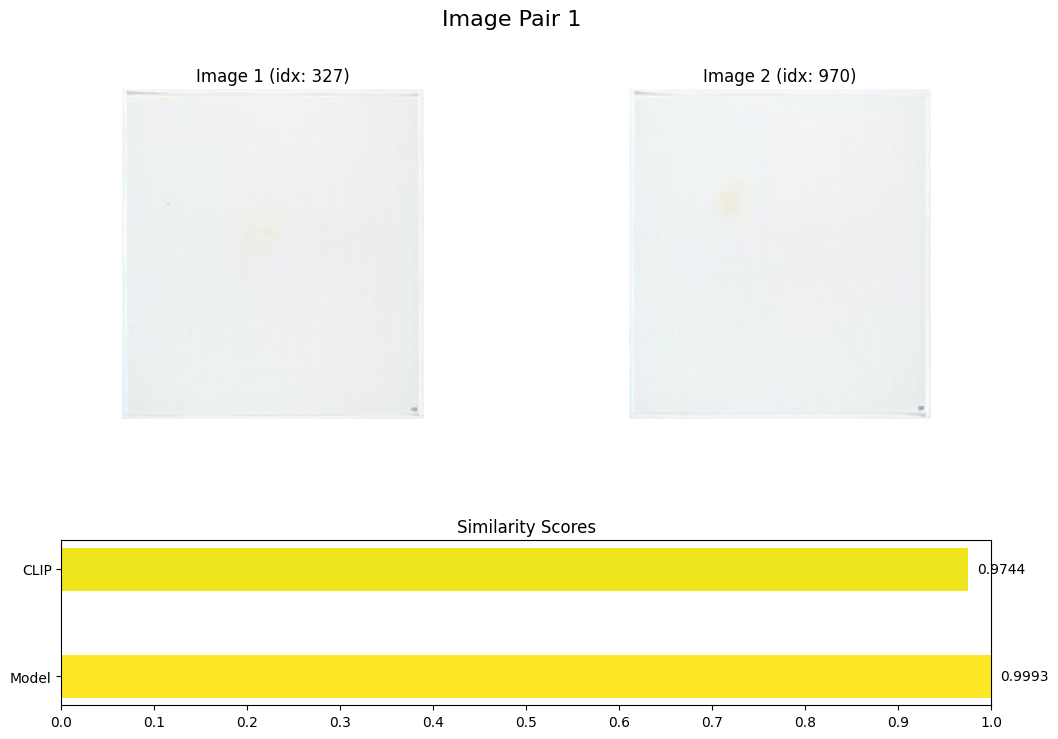

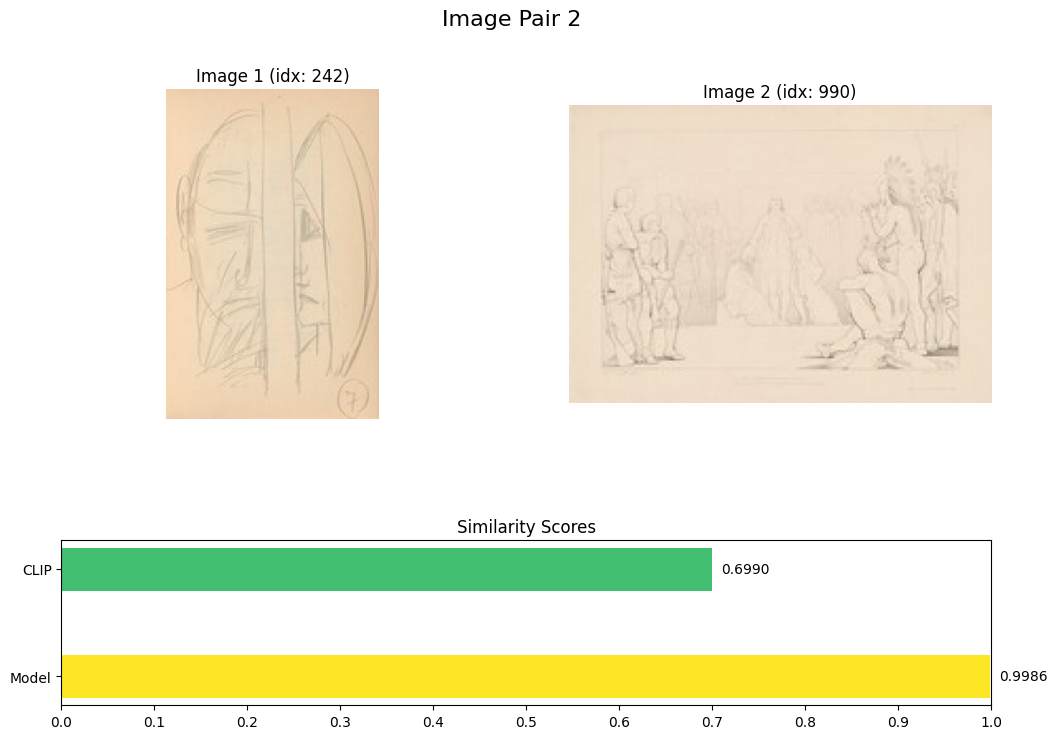

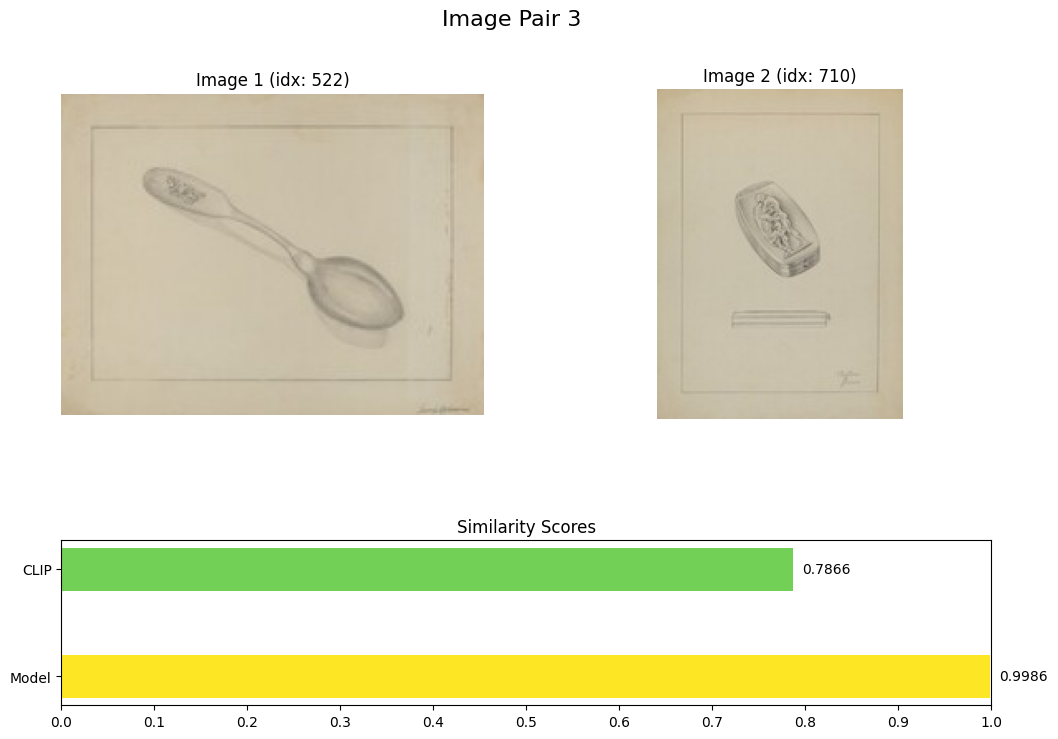

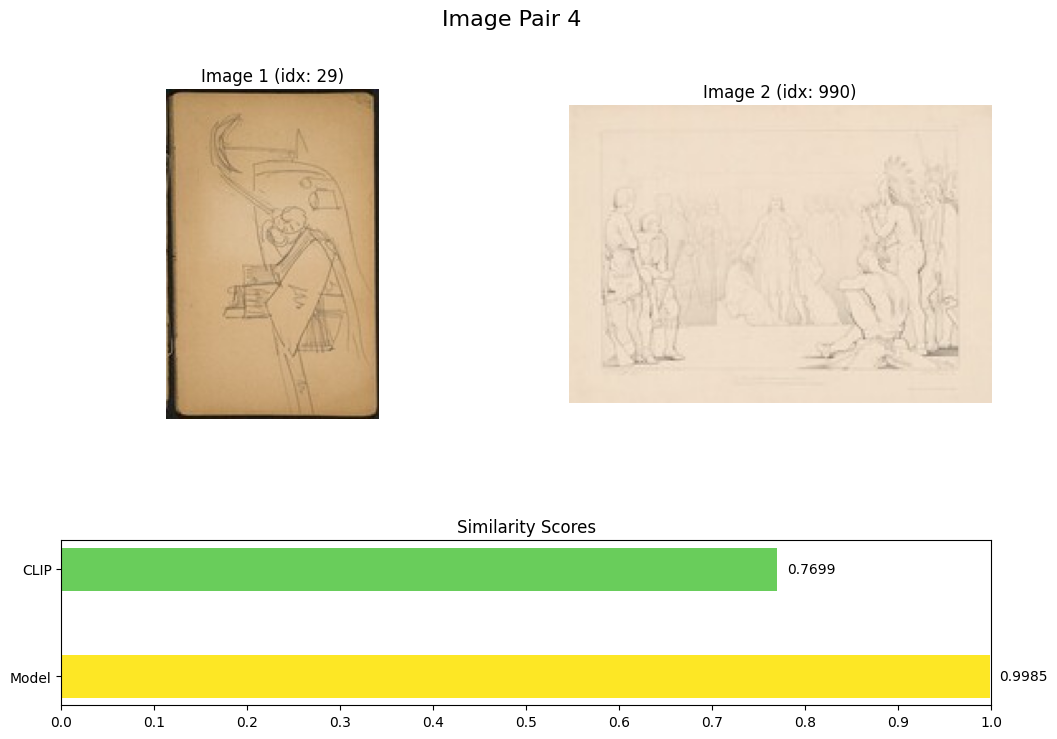

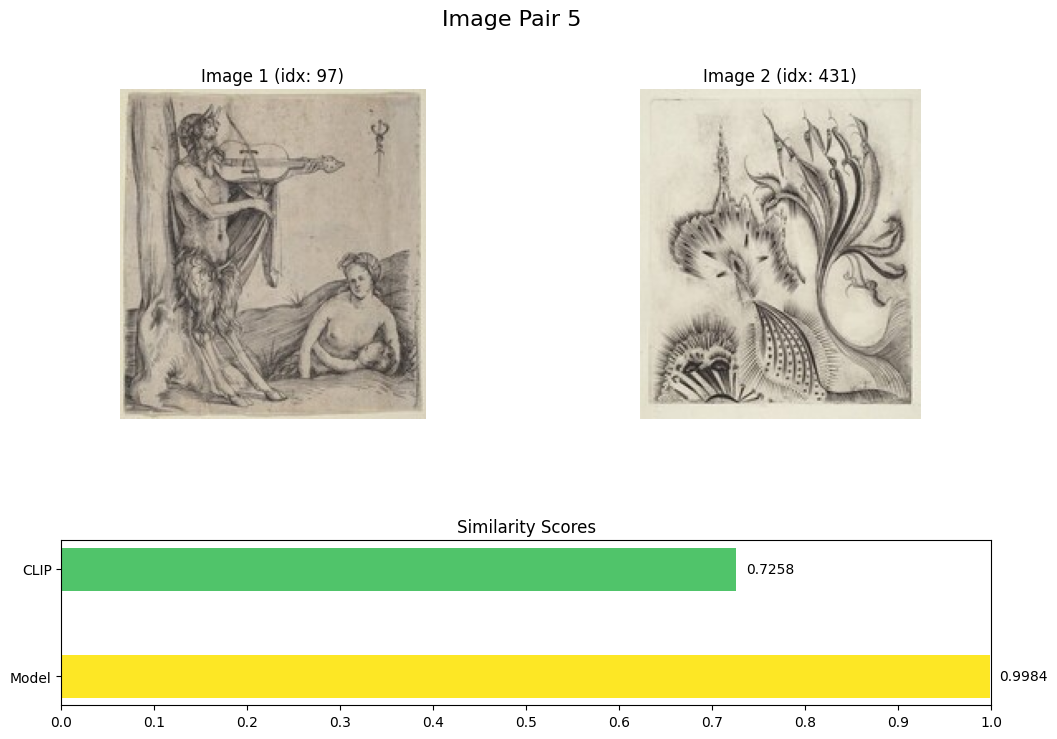

In [20]:
# Visualize image pairs
visualize_image_pairs(result_data)